Note: needs the questions.json file in the same directory as this file.

- It should contain all of the questions in the database dumped from mongodb.

In [1]:
import json
import numpy as np

from matplotlib import pyplot as plt
from tqdm import tqdm

np.random.seed(0)

In [2]:
def hhi(arr):
    return sum([_**2 for _ in arr]) / sum(arr) ** 2


def normalized_hhi(arr):
    return (hhi(arr) - 1/len(arr)) / (1 - 1/len(arr))


def removePunctuation(s, punctuation='''.,!-;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    return ''.join(ch for ch in s if ch not in punctuation)


questions = open('tossups.json').readlines() + open('bonuses.json').readlines()
np.random.shuffle(questions)
print('Number of questions:', len(questions))

with open('stop-words.txt') as f:
    stop_words = set(f.readlines())
    stop_words = set([word.strip() for word in stop_words])

with open('subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

word_to_subcat = {}

for line in tqdm(questions):
    data = json.loads(line)
    if 'subcategory' not in data: continue

    subcategory = data['subcategory']

    if subcategory not in SUBCATEGORIES: continue
    subcategory_index = SUBCATEGORIES.index(subcategory)

    if data['type'] == 'tossup':
        tokens = removePunctuation(data['question']).lower().split()
    if data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        tokens = removePunctuation(data['leadin'] + ' ' + data['parts'][0] + data['parts'][1] + data['parts'][2]).lower().split()

    tokens = [token for token in tokens if token not in stop_words]
    for token in tokens:
        if token not in word_to_subcat:
            word_to_subcat[token] = [0 for _ in range(len(SUBCATEGORIES))]

        word_to_subcat[token][subcategory_index] += 1

Number of questions: 237637


100%|██████████| 237637/237637 [00:38<00:00, 6121.90it/s]


In [3]:
factors = {}

for word in word_to_subcat:
    factors[word] = normalized_hhi(word_to_subcat[word])

In [4]:
hhis = list(factors.values())
hhis.sort()

In [5]:
n = len(hhis)

print(f'Average HHI: {sum(hhis) / len(hhis)}')
print(f'Median HHI: {hhis[n // 2]}')
print(f'{len([i for i in hhis if i == 1.0])} words with HHI = 1.0')

Average HHI: 0.8315991264473938
Median HHI: 1.0
387639 words with HHI = 1.0


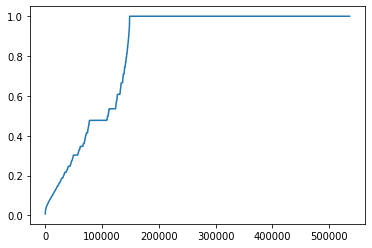

In [6]:
plt.plot(hhis)
plt.show()

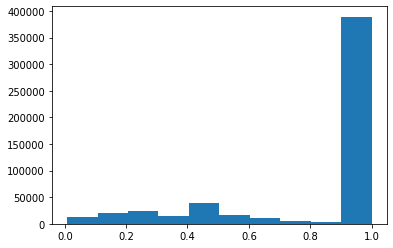

In [7]:
plt.hist(hhis)
plt.show()